# Model distilBert2 train

Training of neural network classifier to fine-tune the DistilBert pretrained transformer model, with a more complex architecture with respect to distilBert1.

The fine-tuning part was replaced by a Bidirectional Long Short-Term Memory (LSTM) layer with 128 units. The LSTM architecture has a strong tie to many NLP tasks, and it was successfully applied as a fine-tuning layer to pre-trained BERT-like models. This layer was followed by a pooling layer, a dense layer with 64 units and a ReLU activation function and a dropout layer.

In [1]:
import warnings
warnings.filterwarnings("ignore")
from transformers import logging as hf_logging
hf_logging.set_verbosity_error() # hide transformers library warning messages

import numpy as np
import os
import pickle
import pandas as pd
from sklearn import metrics
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import matplotlib.pyplot as plt

import transformers
from transformers import DistilBertTokenizerFast, TFDistilBertModel, DistilBertConfig
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from trainevalutils import *

from tqdm import tqdm

In [2]:
MAX_LENGTH = 256

In [3]:
THIS_MODEL_NAME = 'distilBert'
VERSION = '2'

RESULT_DIR = '../results/'
OUTPUT_DIR = '../models/wip/'+THIS_MODEL_NAME+'/'
CHECKPOINTS_DIR = OUTPUT_DIR + 'checkpoints/'
MODEL_DIR = OUTPUT_DIR + THIS_MODEL_NAME + VERSION + '/'
HISTORY_DIR = OUTPUT_DIR + 'history/'
LOGS_DIR = OUTPUT_DIR + 'logs/'

for dir_ in [OUTPUT_DIR, CHECKPOINTS_DIR, MODEL_DIR, HISTORY_DIR, LOGS_DIR, RESULT_DIR]:
    if not os.path.exists(dir_):
        os.makedirs(dir_)

In [4]:
SEED = 3742
tf.random.set_seed(SEED)

class_names = pickle.load(open("../data/class_labels_dic.pkl", 'rb'))

TRANSFORMER_MODEL_NAME = 'distilbert-base-cased'

In [6]:
l = str(MAX_LENGTH)
X_train = pickle.load(open("../data/wip/dB/X_train_tot_"+l+".pkl", 'rb'))
y_train = pickle.load(open("../data/wip/dB/y_train_tot_"+l+".pkl", 'rb'))

X_val = pickle.load(open("../data/wip/dB/X_val_tot_"+l+".pkl", 'rb'))
y_val = pickle.load(open("../data/wip/dB/y_val_tot_"+l+".pkl", 'rb'))

In [11]:
def build_model(NUM_CLASSES):
    
    config = DistilBertConfig.from_pretrained(TRANSFORMER_MODEL_NAME, output_hidden_states=True, output_attentions=True)
    DistilBERT = TFDistilBertModel.from_pretrained(TRANSFORMER_MODEL_NAME, config=config)

    input_ids_in = tf.keras.layers.Input(shape=(MAX_LENGTH,), name='input_token', dtype='int32')
    input_masks_in = tf.keras.layers.Input(shape=(MAX_LENGTH,), name='masked_token', dtype='int32') 

    embedding_layer = DistilBERT(input_ids = input_ids_in, attention_mask = input_masks_in)[0]
  
    X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(embedding_layer)
    X = tf.keras.layers.GlobalMaxPool1D()(X)
    X = tf.keras.layers.Dense(64, activation='relu')(X)
    X = tf.keras.layers.Dropout(0.2)(X)

    output = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(X)
    model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = output)

    # Freezeing DistilBert layer
    for layer in model.layers[:3]:
        layer.trainable = False

    return model

In [12]:
NUM_CLASSES = len(class_names)

model = build_model(NUM_CLASSES)

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 256)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 256)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  65190912   ['input_token[0][0]',            
 BertModel)                     ast_hidden_state=(N               'masked_token[0][0]']           
                                one, 256, 768),                                                   
                                 hidden_states=((No                                           

## Checkpoint monitoring setup

A checkpoint model file will be saved if there was an improvement from the previous epoch, in terms of validation loss (val_loss). However, if training was interrupted and it is restarting from a previously saved checkpoint, the calculations will not look at the values achieved in the previous checkpoint. Therefore, if on the first restarting iteration val_loss did not improve with respect to the last saved checkpoint, a new model checkpoint file will be created anyway.

In [14]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=CHECKPOINTS_DIR+'CHCKPNT-ep{epoch:02d}-vlos{val_loss:.2f}.hdf5',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    factor=0.1,
    patience=1,
    verbose=1,
    min_delta=0.01,
    min_lr=0.000001
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    min_delta=0,
    patience=3,
    verbose=1,
    restore_best_weights=False
)

csv_logger = tf.keras.callbacks.CSVLogger(
    filename = LOGS_DIR + 'training_log.csv',
    separator=',',
    append=True
)

# Calculate the class weights
class_weights = compute_class_weight('balanced', classes= np.unique(y_train), y=y_train)
class_weights = {i : class_weights[i] for i in range(NUM_CLASSES)}

print("Class weights:", class_weights)

Class weights: {0: 0.4545195539839763, 1: 1.1477398655116995, 2: 1.3942740747527858, 3: 4.730862130814301}


In [15]:
resuming_training = True
try:
    log = pd.read_csv(LOGS_DIR+'training_log.csv')
except FileNotFoundError:
    resuming_training = False
    log = pd.DataFrame({"epoch":[0]})
    print("Training starts from epoch 0.")

log

,epoch,accuracy,loss,lr,precision,recall,val_accuracy,val_loss,val_precision,val_recall
0,0,0.882354,0.381688,0.00100,0.896450,0.869988,0.892497,0.277483,0.907554,0.878726
1,1,0.893100,0.345697,0.00100,0.904425,0.883214,0.897636,0.258438,0.907807,0.889393
2,2,0.895934,0.333705,0.00100,0.907013,0.886445,0.899852,0.248627,0.910298,0.891409
3,3,0.902611,0.308331,0.00010,0.912319,0.894420,0.904768,0.237606,0.913645,0.897167
4,4,0.904740,0.300501,0.00010,0.913734,0.897189,0.901972,0.242238,0.910214,0.895394
5,5,0.906034,0.294941,0.00001,0.914764,0.898534,0.905624,0.235730,0.913497,0.899150
6,6,0.898966,0.320993,0.00100,0.909244,0.890215,0.903540,0.249289,0.915716,0.893826
7,7,0.899909,0.317657,0.00100,0.909964,0.891291,0.904203,0.237825,0.913898,0.896178
8,8,0.900618,0.313945,0.00100,0.910703,0.892128,0.899849,0.247677,0.909700,0.891889
9,9,0.902050,0.308240,0.00100,0.911433,0.894116,0.903966,0.244277,0.914429,0.895255


## Training setup

In [16]:
## reload weighths if it's a retraining session
if resuming_training: 
    if len((os.listdir(MODEL_DIR))) == 0:
        checkpointName = input('Enter checkpoint file name: ')
        checkpoint = CHECKPOINTS_DIR + checkpointName
    else:
        checkpoint = MODEL_DIR
    model.load_weights(checkpoint)

In [17]:
METRICS = [tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.Precision(name='precision'),
           'accuracy'
          ]

OPTIMIZER = tf.keras.optimizers.Adam()

LOSS='categorical_crossentropy'

model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)

In [18]:
y_train_1hot = tf.one_hot(y_train, NUM_CLASSES)
y_val_1hot = tf.one_hot(y_val, NUM_CLASSES)

## Training run

In [14]:
MAX_EPOCHS = 12
BATCH_SIZE = 64

initial_epoch = log["epoch"].iloc[-1:].values[0]
if resuming_training: initial_epoch += 1


history = model.fit(X_train, 
                    y_train_1hot, 
                    epochs = MAX_EPOCHS, initial_epoch=initial_epoch,
                    batch_size = BATCH_SIZE, 
                    validation_data=(X_val, y_val_1hot), 
                    callbacks=[model_checkpoint, early_stopping, reduce_lr, csv_logger],
                    class_weight=class_weights
                   )


model.save_weights(MODEL_DIR)

with open(HISTORY_DIR+'history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 10/12
24728/24728 [==============================] - ETA: 0s - loss: 0.3082 - recall: 0.8941 - precision: 0.9114 - accuracy: 0.9020
Epoch 10: val_loss improved from inf to 0.24428, saving model to ../models/wip/distilBert/checkpoints/CHCKPNT-ep10-vlos0.24.hdf5
24728/24728 [==============================] - 6641s 268ms/step - loss: 0.3082 - recall: 0.8941 - precision: 0.9114 - accuracy: 0.9020 - val_loss: 0.2443 - val_recall: 0.8953 - val_precision: 0.9144 - val_accuracy: 0.9040 - lr: 0.0010
Epoch 11/12
24728/24728 [==============================] - ETA: 0s - loss: 0.3052 - recall: 0.8951 - precision: 0.9121 - accuracy: 0.9029
Epoch 11: val_loss improved from 0.24428 to 0.23683, saving model to ../models/wip/distilBert/checkpoints/CHCKPNT-ep11-vlos0.24.hdf5

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
24728/24728 [==============================] - 6626s 268ms/step - loss: 0.3052 - recall: 0.8951 - precision: 0.9121 - accuracy: 0.9029 - val_loss: 0

## Evaluation

Highest Validation Precision: epoch 7
Highest Validation Recall: epoch 12
Highest Validation Accuracy: epoch 12
Lowest Validation Loss: epoch 12


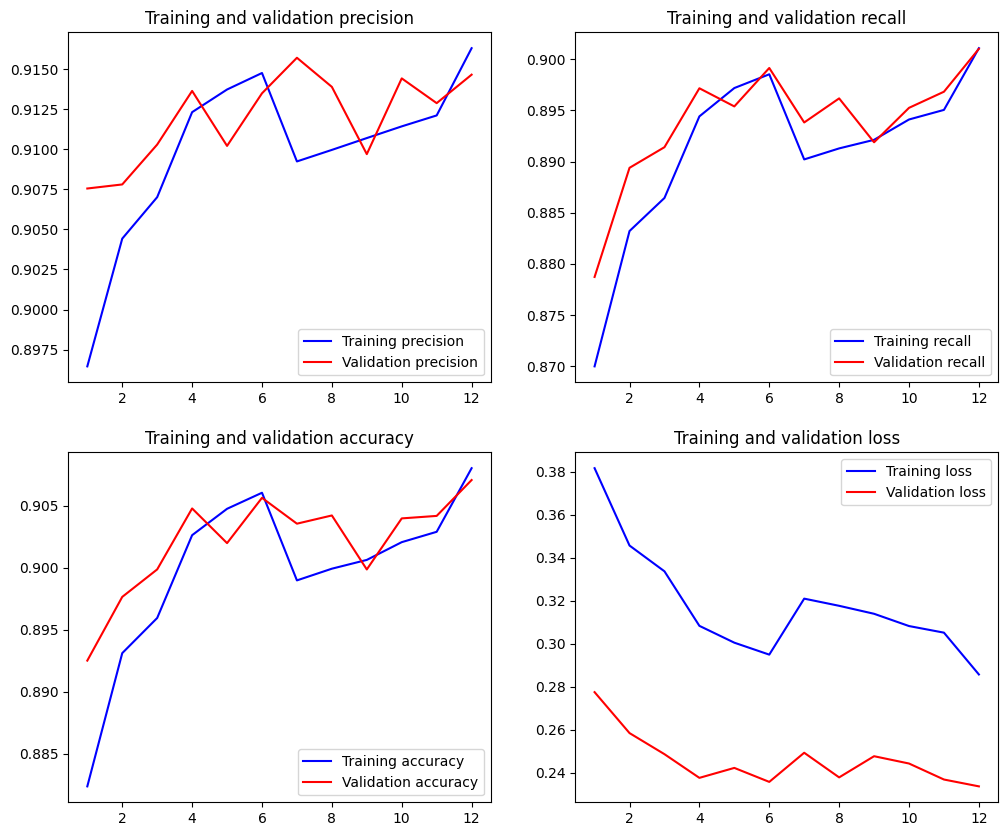

In [16]:
def load_history():
    if resuming_training:
        log = pd.read_csv(LOGS_DIR+'training_log.csv')
        data_dict = log.drop("epoch", axis=1).to_dict()
        output_dict = {}
        for key in data_dict.keys():
            output_dict[key] = list(data_dict[key].values())
        return output_dict
    return history.history

history_dict = load_history()
plot_history(history_dict)

### Selection of epoch to use for evaluation
Human contribution: the model to evaluate can be loaded from a previous epoch, if required after the history plot analysis.

In [ ]:
# if needed, reload a model from a previous checkpoint file.
checkpointName = input('Enter checkpoint file name: ')
checkpoint = CHECKPOINTS_DIR + checkpointName
model.load_weights(checkpoint)

In [19]:
def evaluate_nn(name, X, y_actual):
    y_probs = model.predict(X)

    y_pred = []
    for prob in y_probs:
        y_pred.append(np.argmax(prob))

    res = generate_model_report(name, y_actual, y_pred)

    report = metrics.classification_report(y_actual, y_pred, target_names=target_names.values())
    print(f'\nClassification report:\n{report}')
    return res

In [22]:
result_train = evaluate_nn(THIS_MODEL_NAME+VERSION+'train', X_train, y_train)

49456/49456 [==============================] - 4988s 101ms/step
Accuracy: 0.9140529822415214
Precision (macro): 0.8294398122275859
Recall (macro): 0.8930638811795426
F1-score (macro): 0.8479084646720632

Classification report:
              precision    recall  f1-score   support

     Physics       0.99      0.94      0.97    870462
 Mathematics       0.91      0.91      0.91    344714
Computer Sc.       0.91      0.83      0.87    283762
       Other       0.51      0.88      0.64     83630

    accuracy                           0.91   1582568
   macro avg       0.83      0.89      0.85   1582568
weighted avg       0.93      0.91      0.92   1582568



In [19]:
result_val = evaluate_nn(THIS_MODEL_NAME+VERSION+'_val', X_val, y_val)

8728/8728 [==============================] - 869s 100ms/step
Accuracy: 0.9070600156833538
Precision (macro): 0.8178162288626112
Recall (macro): 0.8769358710903262
F1-score (macro): 0.8350427587319458

Classification report:
              precision    recall  f1-score   support

     Physics       0.98      0.94      0.96    153261
 Mathematics       0.90      0.91      0.91     60818
Computer Sc.       0.90      0.82      0.86     50476
       Other       0.48      0.84      0.61     14722

    accuracy                           0.91    279277
   macro avg       0.82      0.88      0.84    279277
weighted avg       0.93      0.91      0.91    279277



In [20]:
df_result = pd.DataFrame([result_val])

df_result

,Description,Accuracy,Precision,Recall,F1-score
0,distilBert2_val,0.90706,0.817816,0.876936,0.835043


In [21]:
df_result.to_pickle(RESULT_DIR+'results_'+THIS_MODEL_NAME+VERSION+'.pkl')

### Predictions on test dataset

Final evaluation on previously unseen test data after analysing the results from all models (See validation result analysis in the next notebook)

In [14]:
X_test = pickle.load(open("../data/wip/dB/X_test_tot_"+l+".pkl", 'rb'))
y_test = pickle.load(open("../data/wip/dB/y_test_tot_"+l+".pkl", 'rb'))

In [27]:
y_probs = model.predict(X_test)
y_pred_final = []
for prob in y_probs:
    y_pred_final.append(np.argmax(prob))

10268/10268 [==============================] - 1011s 98ms/step


In [29]:
pickle.dump(y_pred_final, open('test_set_preds/results_TEST_SET.pkl','wb'))

In [30]:
res = generate_model_report("test_data_final", y_test, y_pred_final)
report = metrics.classification_report(y_test, y_pred_final, target_names=target_names.values())
print(f'\nFinal classification report on test set:\n{report}')

Accuracy: 0.907110377949976
Precision (macro): 0.8174431974740399
Recall (macro): 0.8762818319157644
F1-score (macro): 0.8344621324911778

Final classification report on test set:
              precision    recall  f1-score   support

     Physics       0.98      0.94      0.96    180999
 Mathematics       0.91      0.91      0.91     71066
Computer Sc.       0.90      0.82      0.86     59196
       Other       0.48      0.84      0.61     17301

    accuracy                           0.91    328562
   macro avg       0.82      0.88      0.83    328562
weighted avg       0.93      0.91      0.91    328562



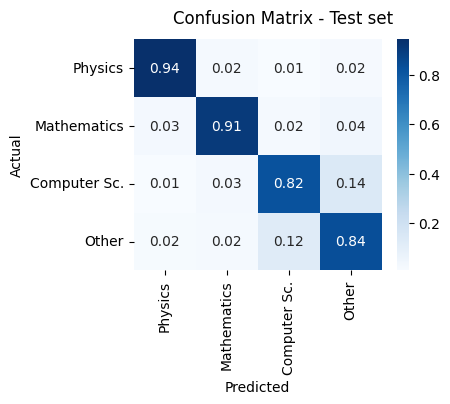

In [57]:
target_names = pickle.load(open("../data/class_labels_dic.pkl", 'rb'))

cm = metrics.confusion_matrix(y_test, y_pred_final)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(4, 3))


sns.heatmap(cm_norm, annot=True, cmap='Blues', fmt='.2f', xticklabels=class_names.values(), yticklabels=target_names.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.suptitle("Confusion Matrix - Test set\n")
plt.show()

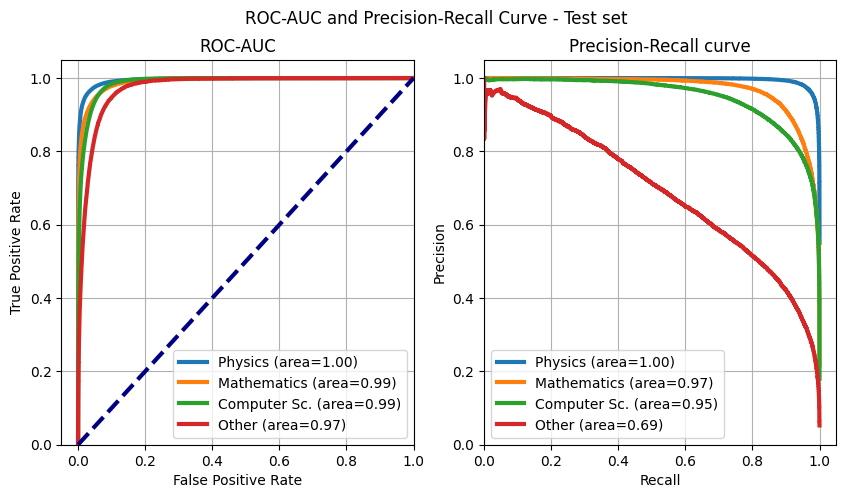

In [56]:
fig, ax = plt.subplots(figsize=(10, 5), nrows=1, ncols=2)

y_test_array = pd.get_dummies(y_test, drop_first=False).values
## roc-auc
for i in range(len(target_names)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           y_probs[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(target_names[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate", 
          title="ROC-AUC")
ax[0].legend(loc="best")
ax[0].grid(True)
    
## precision-recall
for i in range(len(target_names)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], y_probs[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(target_names[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.suptitle("ROC-AUC and Precision-Recall Curve - Test set\n")
plt.show()